# Regression kriging

## Kriging

Spatial interpolation is the process of estimating the target value at locations where we do not have observations using the values at nearby locations where there are observations. It aims to generate a complete surface of estimate target values from a sample of locations where the target variable is observed.

One method to implement spatial interpolation is kriging, a geostatistical approach, which estimates the value at the unknown location as a weighted average of values at nearby locations. 

$$
\hat{z}(s_{0}) = \sum_{i=1}^{n} \gamma_{i}z(s_{i})
$$

where $\hat{z}(s_{0})$ the estimated target value at the candidate location for prediction, $z(s_{i})$ are nearby locations where the target value is observed, and $\gamma_{i}$ are weights. The weights are a function of the distance between observation $i$ and teh candidate location for prediction $0$ and the spatial autocorrelation structure of the data. Considering the spatial autocorrelation structure of the data makes kriging different from interpolation schemes that only consider distance weighted observations (e.g. inverse distance weighting). In kriging the spatial autocorrelation structure of the data is modelled using variograms; these will introduced and demonstrated in this notebook. 

## Predictive mapping and geospatial machine learning

An alternative approach to generating a surface of estimated target values is to use a machine learning model that predicts the target value based on predictor variables with complete spatial coverage. A machine learning model is trained to learn relationships between input predictor variables and target values; a simple machine learning model is a regression model:

$$
\hat{y} = b + w_{1}x_{1}
$$

Where the parameter values for $b$ and $w_{1}$ are learnt during training to minimise prediction error of the target value. This model can be applied everywhere there is coverage of the predictor variable $x_{1}$ to generate a predicted map of the target value. The advantage of predictive mapping using machine learning is a wide range of predictor variables that are correlated with the target value can be used in estimating the target value at unknown locations. Also, these predictor variables might include direct observations of conditions at the candidate location for prediction. This contrasts with kriging where conditions at the candidate site for prediction are inferred from a model of the spatial autocorrelation structure of the data and the distance to locations with observations of the target value.   

## Regression kriging

Regression kriging is a combination of predictive mapping using a machine learning model and interpolation via kriging. Regression kriging generates a predictive map via the following process: 

1. A machine learning model is developed using predictor variables with complete spatial coverage. 
2. The model is then used to generate predictions at locations where there are observations of the target value. 
3. The residuals are computed as the difference the predicted and observed target values. 
4. A complete spatial surface is predicted using the trained model and predictor variables. 
5. The residuals are interpolated using kriging.
6. The predicted map and the residuals are added together to yield the final predicted surface. 

Regression kriging can be defined mathematically as:

$$
\hat{z}(s_{0}) = b + w_{1}x_{0} + \sum_{i=1}^{n} \gamma_{i}z(s_{i})
$$

Where $x_{0}$ is the predictor variable at the candidate location for prediction $0$. 



## Setup

### Load data

In [2]:
import os
import subprocess

if "data-geoml" not in os.listdir(os.getcwd()):
    subprocess.run('wget "https://github.com/envt-5566/geo-ml/raw/main/data/data-geoml.zip"', shell=True, capture_output=True, text=True)
    subprocess.run('unzip "data-geoml.zip"', shell=True, capture_output=True, text=True)
    if "data-geoml.zip" not in os.listdir(os.getcwd()):
        print("Has a directory called data-geoml been downloaded and placed in your working directory? If not, try re-executing this code chunk")
    else:
        print("Data download OK")

DATA_PATH = os.path.join(os.getcwd())

Data download OK


### Load packages

In [3]:
# install pykrige and gstools
!pip install pykrige
!pip install gstools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.7/618.7 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pykrige: filename=PyKrige-1.7.2-cp311-cp311-linux_aarch64.whl size=257989 sha256=d9b319ddfe71061ee9703ea7f426a2dfd369ffc06dba7ed9e67ff80be475c8de
  Stored in directory: /home/jovyan/.cache/pip/wheels/3d/47/f2/66e3b89fc2890d8df3d62945ce43e30b2a8f69be4ef77b3d1f
Successfully built pykrige
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 6.6 MB/s eta 0:00:00
  Created whee

In [5]:
if 'google.colab' in str(get_ipython()):
    !pip install xarray[complete]
    !pip install rioxarray
    !pip install mapclassify
    !pip install contextily
    !pip install pysal

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import math
from tqdm import tqdm

# geostatistics
import gstools as gs
from pykrige.rk import RegressionKriging

# plotting
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt

# pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

# metrics
from sklearn.metrics import mean_squared_error

## Data import

We will be focusing on using regression kriging to generate a model that predicts plant species richness at a location using bioclimatic variables and elevation as predictors with complete spatial coverage (the machine learning model component of regression kriging) and observations of plant species richness at nearby locations (the spatial interpolation component of regression kriging). 

This is the dataset presented in <a href="https://arxiv.org/html/2404.06978v1" target="_blank">Meyer et al. (2024)</a> that includes points across South America representing vegetation surveys where species richness counts were recorded from the <a href="https://onlinelibrary.wiley.com/doi/10.1111/geb.13346" target="_blank">sPlotOpen database</a>. Species richness counts are the target values. Predictor variables included with this dataset are <a href="https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_BIO#bands" target="_blank">WorldClim bioclimatic variables</a> and elevation. The bioclimatic variables have the following definitions:

* BIO1: Annual Mean Temperature
* BIO2: Mean Diurnal Range (Mean of monthly (max temp - min temp))
* BIO3: Isothermality (BIO2/BIO7) (×100)
* BIO4: Temperature Seasonality (standard deviation ×100)
* BIO5: Max Temperature of Warmest Month
* BIO6: Min Temperature of Coldest Month
* BIO7: Temperature Annual Range (BIO5-BIO6)
* BIO8: Mean Temperature of Wettest Quarter
* BIO9: Mean Temperature of Driest Quarter
* BIO10: Mean Temperature of Warmest Quarter
* BIO11: Mean Temperature of Coldest Quarter
* BIO12: Annual Precipitation
* BIO13: Precipitation of Wettest Month
* BIO14: Precipitation of Driest Month
* BIO15: Precipitation Seasonality (Coefficient of Variation)
* BIO16: Precipitation of Wettest Quarter
* BIO17: Precipitation of Driest Quarter
* BIO18: Precipitation of Warmest Quarter
* BIO19: Precipitation of Coldest Quarter

Let's start by loading and mapping the training data. 

In [6]:
gdf = gpd.read_file(os.path.join(DATA_PATH, "plant_species_south_america.gpkg"))

Let's explore the data on a web map.

In [7]:
gdf.explore(column="Species_richness")

We can see the locations where we have observations of species richness are clustered within the extent of South America. The extent to which observations of species richness are spatially autocorrelated (i.e. locations close to each other have similar plant species richness values) will influence the effectiveness of kriging interpolation estimates of plant species richness at unknown locations.

In kriging, semivariance is used to measure the spatial autocorrelation between observations and semivariograms are used to visualise the spatial autocorrelation structure. 

## Variograms

In kriging, the semivariance is used as a measure of spatial correlation.  The semivariance is defined as half the squared difference between the target value at two locations $h$ distance apart. 

$$
\gamma(h) = \frac{1}{2}[z(x_{i}) - z(x_{j})]^2
$$

Where $\gamma(h)$ is the semivariance and $z(x_{i})$ and $z(x_{j})$ are target values at locations $i$ and $j$ at $h$ distance apart. 

The empircal semivariogram plots the semivariance between all observations in a dataset against the distance between the observation locations. This visualises the spatial autocorrelation structure of the dataset; for example, spatially autocorrelated data examples that are close to each other in space will have small semivariance values as they would have similar values for the target variable. 

To aid interpretation of the semivariogram, often the data is binned by averaging the semivariance scores within certain distance ranges (bins). This can help make the spatial autocorrelation structure clearer amongst noise and scatter in the dataset.  

We can use the <a href="https://geostat-framework.readthedocs.io/projects/gstools/en/stable/api/gstools.variogram.vario_estimate.html#gstools.variogram.vario_estimate" target="_blank">`vario_estimate()` function</a> from the <a href="https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/03_variogram/06_auto_bin_latlon.html" target="_blank">GSTools</a> package. 

### Data pre-processing

In order to generate the variogram we need an array of the coordinates the locations of all the examples in our dataset (this lets us compute the distance between points) and a corresponding array of the target values. Here, we'll compute the semivariogram for the plant species richness observations across South America. 

The following code snippet demonstrates how to create an `x` and `y` column storing the longitude and latitude values for the points. We then subset out the `x` and `y` columns and the target variable `Species_richness` and store them as NumPy `ndarray`s. We also transpose the arrays so they are list-like (values aligned along the 0-axis). This is what the `T` operator does. 

In [8]:
gdf.loc[:, "x"] = gdf.geometry.x
gdf.loc[:, "y"] = gdf.geometry.y

data = gdf.loc[:, "Species_richness"].to_numpy().T
pos = gdf.loc[:, ["x", "y"]].to_numpy().T

### Variogram computation 

Next, we can pass `pos`, an array of coordinates, and `data`, an array of plant species richness values, into the <a href="https://geostat-framework.readthedocs.io/projects/gstools/en/stable/api/gstools.variogram.vario_estimate.html#gstools.variogram.vario_estimate" target="_blank">`vario_estimate()` function</a> to compute the empirical semivariogram. 

Note, we also set the `latlon` argument to `True` as the coordinates are geographic and we want our distance measurements between points to account for the curvature of the Earth. The `geo_scale` argument is also set to `gs.KM_SCALE` to get the variogram bins returned in km scaling and not radians (the units of latitude and longitude). This helps us interpret the semivariogram and the spatial autocorrelation structure. 

In [9]:
emp_v = gs.vario_estimate(pos, data, latlon=True, geo_scale=gs.KM_SCALE)

The <a href="https://geostat-framework.readthedocs.io/projects/gstools/en/stable/api/gstools.variogram.vario_estimate.html#gstools.variogram.vario_estimate" target="_blank">`vario_estimate()` function</a> returns a tuple of two arrays. The first array stores the distance at the centre of bins and the second array stores the semivariance values. We can plot the empirical semivariogram. 

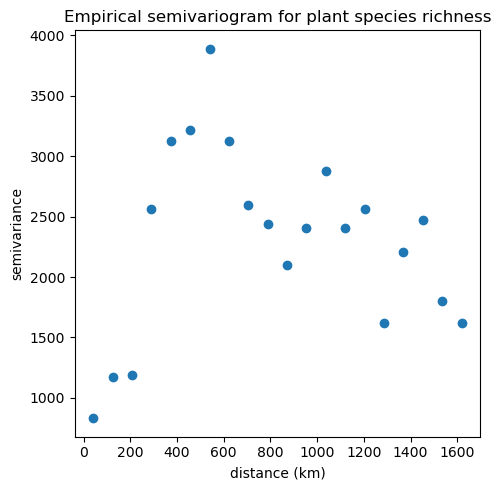

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
ax.scatter(emp_v[0], emp_v[1])
ax.set_title("Empirical semivariogram for plant species richness")
ax.set_ylabel("semivariance")
ax.set_xlabel("distance (km)")
plt.tight_layout()
plt.show()

## Model variograms

The model semivariogram is a mathematical model that best fits the computed semivariogram of the observations. A model is an estimate of the semivariance between two locations any $h$ distance apart, and, thus, it can be used to for guiding interpolation to generate a continuous surface. The empirical semivariogram only records the semivariance between locations where we have observations. However, to generate an interpolated surface we need an estimate of the semivariance at all potential distances between locations. In kriging, the semivariance as a measure of how similar a target value is for points $h$ distance apart is used to weight the contribution of observed values to predicting the value at an unknown location. Therefore, we fit a model to our empirical semivariogram that gives an estimate of the semivariance for all distances between points. 

The GSTools package has an <a href="https://geostat-framework.readthedocs.io/projects/gstools/en/stable/api/gstools.covmodel.Exponential.html#gstools.covmodel.Exponential" target="_blank"><code>Exponential()</code> function</a> that has a `fit()` method. We can pass the empirical semivariogram object into the fit method to estimate an exponential model of the semivariogram. Again, we need to account for the fact our data is in geographic coordinates. 

Model semivariograms are described by the nugget (the semivariance when the distance between points is 0), the sill (the semivariance at the distance between points when the semivariance stops increasing with distance), and the range (the distance at which the semivariance stops increasing or when the spatial corrrelation between points has diminished). 

Model variogram nugget: 189.49335433022205
Model variogram sill: 2443.9297937475485


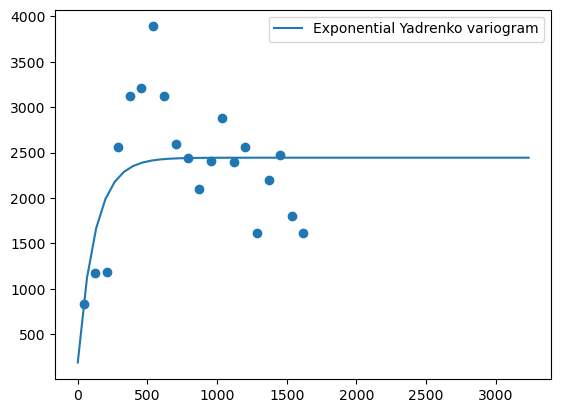

In [12]:
exp = gs.Exponential(latlon=True, geo_scale=gs.KM_SCALE)
exp.fit_variogram(*emp_v)
ax = exp.plot("vario_yadrenko", x_max=2 * np.max(emp_v[0]))
ax.scatter(*emp_v)
ax.legend()
print(f"Model variogram nugget: {exp.nugget}")
print(f"Model variogram sill: {exp.sill}")

## Regression kriging

### Data pre-processing

To train a regression kriging model we need three datasets: predictor variables, target values, and the coordinates where we have examples of predictor variables and observed target values. 

Our coordinate values will be in latitude and longitude units. A key part of kriging is measuring the distance between examples; the empirical semivariogram visualises how similar target values are for examples a given distance apart. As latitude and longitude values are geograhic coordinates (i.e. they are not projected coordinates onto a flat surface where we can measure distance in metres) we need to be careful to set up our regression kriging workflow so it is aware that coordinate values are geographic.

The regression model component of regression kriging requires predictor variables and observations of the target value to train the model.

The kriging component of a regression kriging model needs the locations (coordinates) of the training data and observations of the target value in order to model the spatial autocorrelation to generate kriging weights for spatial interpolation. 

We also need to split our data into train and test splits so we can evaluate our regression kriging model. 

In [13]:
# create an array of coordinates
# these are geographic coordinates (i.e. latitude and longitude)
# we need to remember to set up our regression kriging workflow to
# account for spherical coordinates
pos = gdf.loc[:, ["x", "y"]].to_numpy()

# drop columns not needed for model development
gdf_tmp = gdf.drop(columns=["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry", "x", "y"])
X = gdf_tmp.drop(columns=["Species_richness"]).to_numpy()
y = gdf_tmp.loc[:, "Species_richness"].to_numpy()

# set aside 30% of the data as a test split
# set the random state for reproducibility
X_train, X_test, pos_train, pos_test, y_train, y_test = train_test_split(X, pos, y, test_size=0.3, random_state=4) 

Next, we need to standardise our predictor variables. 

In [14]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model development

Regression kriging requires a model which is trained to learn relationships between predictor variables and target values. Let's setup a multi-layer perceptron model that we can train as part of the regression kriging workflow. 

In [15]:
regr_rk = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500)

Next, we need to setup our regression kriging workflow. We create an instance of the `RegressionKriging` class from the `PyKrige` package. We pass in our model which will be trained to predict target values from input predictors and a series of parameters that define the kriging component. Here, we're using an exponential variogram model and we set the `coordinates_type` to `"geographic"`. 

In [16]:
m_rk = RegressionKriging(regression_model=regr_rk, n_closest_points=10, variogram_model="exponential", coordinates_type="geographic")

Similar to other `scikit-learn` models we have been working with, `RegressionKriging` objects have a `fit()` method. Calling `fit()` on `m_rk`, our `RegressionKriging` object, will do two things:

* Train a model to predict target values from input predictor variables. This would be the same as in a normal machine learning workflow.
* Fit a variogram model to the emprical semivariogram of the residuals of predictions obtained after training the model.
* Krige the residuals.  

In [17]:
m_rk.fit(X_train_scaled, pos_train, y_train)

Finished learning regression model
Finished kriging residuals


### Model evaluation

We can evaluate our regression kriging model using the normal strategy of comparing model predictions of target values to observed values for a held out test set. We can use a trained `RegressionKriging` model object's `predict()` method to generate these predictions for the test set. 

In [18]:
y_rk_test_preds = m_rk.predict(X_test_scaled, pos_test)

With predicted and observed target values for the test set, we can estimate the model's error using a performance metric. 

In [19]:
test_mse = mean_squared_error(y_test, y_rk_test_preds)
print(f"The MSE on the test split is: {test_mse}")
print(f"The RMSE on the test split is: {math.sqrt(test_mse)}")

The MSE on the test split is: 730.1292804576436
The RMSE on the test split is: 27.020904508503108


Let's compare the regression kriging workflow to a normal machine learning workflow that does not consider the spatial relationship between examples in the training dataset. 

In [20]:
regr = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500)
regr.fit(X_train_scaled, y_train)
y_test_preds = regr.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_preds)
print(f"The MSE on the test split is: {test_mse}")
print(f"The RMSE on the test split is: {math.sqrt(test_mse)}")

The MSE on the test split is: 793.8455457412034
The RMSE on the test split is: 28.175264785644934


#### Activity!

<details>
    <summary><strong>Consider how we have evaluated our regression kriging model. Can you suggest a different strategy for evaluating the regression kriging model that accounts for the spatial structure of the training data?</summary>
    
The ideal strategy would be to generate a representative probability sample over the target area we wish to generate predicted map. However, it might be impossible to generate such a dataset. Alternatively, spatial k-fold cross-validation could be used to estimate model error when generating predictions far away from where the training data was collected. 

</details>

#### Activity!

Let's load another dataset consisting of points collected over the Marburg Forest in Germany and are from the paper by <a href="https://www.sciencedirect.com/science/article/abs/pii/S0304380019303230" target="_blank">Meyer et al. (2019)</a>. Each point has a lead area index (LAI) value and a series of predictor variables derived from a <a href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED" target="_blank">Sentinel-2 satellite image</a> and topographic variables. 

**Can you plot the empirical semivariogram for the LAI values?**

**Can you fit a regression kriging model to predict LAI values based on the Sentinel-2 satellite observations, topographic variables, and kriging the residuals of a fitted machine learning model?**

In [21]:
gdf = gpd.read_file(os.path.join(DATA_PATH, "lai_meyer_et_al_2019_marburg.geojson"))
gdf = gdf.drop(columns=["field_1", "ID", "x_utm_25832", "y_utm_25832"])
gdf = gdf.to_crs("EPSG:4326")
gdf.head()

,B02,B03,B04,B08,B05,B06,B07,B11,B12,B8A,dem,slope,aspect,LAI,geometry
0,785,594,372,1852,593.0000,1508.6250,1839.6875,699.6875,290.1250,1960.6875,320.776764,0.245344,5.787806,11.59900,POINT (8.66774 50.8391)
1,778,602,363,1988,597.5625,1575.3125,1939.5625,700.2500,285.6250,2085.8125,322.118378,0.261233,5.744706,10.73155,POINT (8.66788 50.8391)
2,784,611,365,2091,613.6875,1637.9375,2018.1875,717.2500,281.8750,2182.4375,323.610901,0.276209,5.713427,10.15847,POINT (8.66803 50.8391)
3,762,613,361,2038,622.3125,1663.7500,2057.7500,728.0625,284.9375,2231.6875,325.171997,0.295282,5.709146,10.15847,POINT (8.66817 50.8391)
4,780,607,358,2070,623.4375,1652.7500,2058.2500,732.6875,294.8125,2233.5625,326.905609,0.306035,5.740194,9.66879,POINT (8.66831 50.8391)


<details>
    <summary><strong>Can you plot the empirical semivariogram for the LAI values?</summary>
    
```
gdf.loc[:, "x"] = gdf.geometry.x
gdf.loc[:, "y"] = gdf.geometry.y

data = gdf.loc[:, "LAI"].to_numpy().T
pos = gdf.loc[:, ["x", "y"]].to_numpy().T

emp_v = gs.vario_estimate(pos, data, latlon=True, geo_scale=gs.KM_SCALE)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
ax.scatter(emp_v[0], emp_v[1])
ax.set_title("Empirical semivariogram for LAI")
ax.set_ylabel("semivariance")
ax.set_xlabel("distance (km)")
plt.tight_layout()
plt.show()
```
 
</details>

<details>
    <summary><strong>Can you fit a regression kriging model to predict LAI values based on the Sentinel-2 satellite observations, topographic variables, and kriging the residuals of a fitted machine learning model?</summary>
    
```
# create an array of coordinates
# these are geographic coordinates (i.e. latitude and longitude)
# we need to remember to set up our regression kriging workflow to
# account for spherical coordinates
pos = gdf.loc[:, ["x", "y"]].to_numpy()

# drop columns not needed for model development
gdf_tmp = gdf.drop(columns=["geometry", "x", "y"])
X = gdf_tmp.drop(columns=["LAI"]).to_numpy()
y = gdf_tmp.loc[:, "LAI"].to_numpy()

# set aside 30% of the data as a test split
# set the random state for reproducibility
X_train, X_test, pos_train, pos_test, y_train, y_test = train_test_split(X, pos, y, test_size=0.3, random_state=4) 

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# setup and fit the regression kriging model
regr_rk = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500)
m_rk = RegressionKriging(regression_model=regr_rk, n_closest_points=10, variogram_model="exponential", coordinates_type="geographic")
m_rk.fit(X_train_scaled, pos_train, y_train)

# predict LAI at test location
y_rk_test_preds = m_rk.predict(X_test_scaled, pos_test)

# model evaluation
test_mse = mean_squared_error(y_test, y_rk_test_preds)
print(f"The MSE on the test split is: {test_mse}")
print(f"The RMSE on the test split is: {math.sqrt(test_mse)}")
```
 
</details>